# 1. Setup and Installation

In [2]:
# Install required packages
!pip install -q transformers torch pandas nltk matplotlib scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.0 MB/s eta 0:00:00


In [3]:
 # Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import torch
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from transformers import BertModel, BertTokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')

# Set seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# 2. Loading and Exploring the ICD-11 Data

In [4]:
# Load the ICD-11 data
icd11_df = pd.read_csv('icd11_data_raw.csv')

# Basic data exploration
print(f"Total number of ICD-11 codes: {len(icd11_df)}")
print(f"Number of columns: {len(icd11_df.columns)}")

# Display the first few rows
icd11_df.head()

Total number of ICD-11 codes: 28087
Number of columns: 19


,id,code,title,browser_url,class_kind,definition,parent,inclusions,foundation_children,foundation_child_references,index_terms,related_entities,full_text,children,postcoordination_scales,index_term_references,exclusions,exclusion_references,fully_specified_name
0,1937339080,1C22,Infections due to Chlamydia psittaci,https://icd.who.int/browse/2023-01/mms/en#1937...,category,Any condition caused by an infection with the ...,1127435854,Psittacosis; Ornithosis; Parrot fever,Pneumonia in chlamydia psittaci infection,Pneumonia in chlamydia psittaci infection: htt...,Infections due to Chlamydia psittaci; Psittaco...,1935107489,Infections due to Chlamydia psittaci Any condi...,NaN,NaN,NaN,NaN,NaN,NaN
1,1671640403,1F51.0,Gambiense trypanosomiasis,https://icd.who.int/browse/2023-01/mms/en#1671...,category,A disease caused by an infection with the prot...,875488052,West African sleeping sickness; Infection due ...,NaN,NaN,NaN,1945127438,Gambiense trypanosomiasis A disease caused by ...,1842725899; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
2,1528414070,1A07,Typhoid fever,https://icd.who.int/browse/2023-01/mms/en#1528...,category,A condition caused by an infection with the gr...,135352227,NaN,NaN,NaN,NaN,911707612,Typhoid fever A condition caused by an infecti...,364534567; other; unspecified,"{'axis_name': 'hasManifestation', 'required': ...",NaN,NaN,NaN,NaN
3,328097188,1A36.12,Cutaneous amoebiasis,https://icd.who.int/browse/2023-01/mms/en#3280...,category,NaN,1777228366,NaN,NaN,NaN,Cutaneous amoebiasis; Amoebiasis of skin; Amoe...,911707612,Cutaneous amoebiasis Cutaneous amoebiasis; Amo...,NaN,NaN,NaN,NaN,NaN,NaN
4,1483190070,1D03,Infectious abscess of the central nervous system,https://icd.who.int/browse/2023-01/mms/en#1483...,category,A focal suppurative process of the brain paren...,1585949804,NaN,NaN,NaN,NaN,911707612,Infectious abscess of the central nervous syst...,443087096; 613341872; 1147230459; 1128677700; ...,"{'axis_name': 'specificAnatomy', 'required': '...",NaN,NaN,NaN,NaN


In [5]:
# Check missing values
missing_values = icd11_df.isnull().sum()
print("Missing values per column:")
print(missing_values)

# Check examples of text content in key columns
print("\nExample title:", icd11_df['title'].iloc[0])
if not pd.isna(icd11_df['definition'].iloc[0]):
    print("Example definition:", icd11_df['definition'].iloc[0][:150], "...")
if not pd.isna(icd11_df['inclusions'].iloc[0]):
    print("Example inclusions:", icd11_df['inclusions'].iloc[0])

Missing values per column:
id                                 0
code                            1510
title                              1
browser_url                        0
class_kind                         0
definition                     20073
parent                             0
inclusions                     26528
foundation_children            26310
foundation_child_references    26310
index_terms                     3590
related_entities               25537
full_text                          0
children                       22664
postcoordination_scales        20958
index_term_references          24249
exclusions                     25595
exclusion_references           25619
fully_specified_name           27993
dtype: int64

Example title: Infections due to Chlamydia psittaci
Example definition: Any condition caused by an infection with the gram-negative bacteria Chlamydia psittaci. These conditions are characterised by variable clinical prese ...
Example inclusions: Psittacos

# 3. Text Preprocessing

In [6]:
import nltk
nltk.download('punkt_tab')

# Text preprocessing function for BERT
def preprocess_text(text, stemming=False):
    """
    Preprocess text for BERT embedding.

    For BERT, we do minimal preprocessing since the model handles
    tokenization and understands word morphology well on its own.

    Parameters:
    -----------
    text : str
        The input text to be preprocessed
    stemming : bool
        Whether to apply stemming (usually not needed for BERT)

    Returns:
    --------
    str
        Preprocessed text
    """
    if pd.isna(text) or text == '':
        return ''

    # Convert to lowercase
    text = text.lower()

    # Remove HTML tags and special characters
    text = re.sub('<.*?>', '', text)
    text = re.sub('[^a-zA-Z0-9\\s]', ' ', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 1]

    # Apply stemming if requested (usually not needed for BERT)
    if stemming:
        stemmer = SnowballStemmer('english')
        tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into text
    processed_text = ' '.join(tokens)

    return processed_text

# Create a combined text field from the most informative columns
# Rather than processing each column separately, we'll combine them to save memory
icd11_df['processed_text'] = icd11_df.apply(
    lambda row: preprocess_text(' '.join([
        str(row['title'] or ''),
        str(row['definition'] or ''),
        str(row['inclusions'] or ''),
        str(row['index_terms'] or '')
    ])), axis=1
)

# Display an example of processed text
print("\nExample of processed text:")
print(icd11_df['processed_text'].iloc[0])

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.



Example of processed text:
infections due chlamydia psittaci condition caused infection gram negative bacteria chlamydia psittaci conditions characterised variable clinical presentations fever cough headaches chills fatigue nausea vomiting diarrhoea pneumonia transmission commonly inhalation aersol contaminated body fluids infected birds direct contact infected birds confirmation identification chlamydia psittaci psittacosis ornithosis parrot fever infections due chlamydia psittaci psittacosis ornithosis parrot fever chlamydophila psittaci infection infections due chlamydophila psittaci


# 4. BERT Model Implementation

In [7]:
# Load the BERT model and tokenizer (using a smaller BERT model to conserve memory)
print("Loading BERT model...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
print("BERT model loaded successfully")

# Function to get BERT embeddings for a text
def get_bert_embedding(text, model, tokenizer, max_length=512):
    """
    Generate BERT embeddings for the given text.

    Parameters:
    -----------
    text : str
        Text to embed
    model : BertModel
        Pre-trained BERT model
    tokenizer : BertTokenizer
        BERT tokenizer
    max_length : int
        Maximum sequence length (longer sequences will be truncated)

    Returns:
    --------
    numpy.ndarray
        768-dimensional embedding vector
    """
    if not text or len(text.strip()) == 0:
        return np.zeros(768)  # Return zero vector for empty text

    # Truncate text if it's too long
    if len(text.split()) > max_length - 2:  # Account for [CLS] and [SEP] tokens
        text = ' '.join(text.split()[:max_length-2])

    # Tokenize and encode the text
    encoded_input = tokenizer(
        text,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=max_length
    )

    # Generate BERT embeddings
    with torch.no_grad():
        outputs = model(**encoded_input)
        # Use the [CLS] token embedding as the document representation
        embedding = outputs.last_hidden_state[:, 0, :].numpy()[0]

    return embedding

Loading BERT model...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BERT model loaded successfully


# 5. Generating Embeddings for ICD-11 Codes

In [8]:
# Process a smaller sample to avoid memory issues
sample_size = 1000  # Adjust based on your available RAM
sample_indices = np.random.choice(range(len(icd11_df)), sample_size, replace=False)
sample_df = icd11_df.iloc[sample_indices].copy().reset_index(drop=True)

# Generate BERT embeddings for the sample
print(f"Generating BERT embeddings for {sample_size} ICD codes...")

# Process in batches to manage memory usage
batch_size = 100
for i in range(0, len(sample_df), batch_size):
    end_idx = min(i + batch_size, len(sample_df))
    print(f"Processing batch {i//batch_size + 1}/{(len(sample_df)-1)//batch_size + 1} ({i} to {end_idx-1})")
    sample_df.loc[i:end_idx-1, 'bert_vector'] = sample_df.loc[i:end_idx-1, 'processed_text'].apply(
        lambda text: get_bert_embedding(text, model, tokenizer)
    )

print("BERT embeddings generated successfully")

Generating BERT embeddings for 1000 ICD codes...
Processing batch 1/10 (0 to 99)
Processing batch 2/10 (100 to 199)
Processing batch 3/10 (200 to 299)
Processing batch 4/10 (300 to 399)
Processing batch 5/10 (400 to 499)
Processing batch 6/10 (500 to 599)
Processing batch 7/10 (600 to 699)
Processing batch 8/10 (700 to 799)
Processing batch 9/10 (800 to 899)
Processing batch 10/10 (900 to 999)
BERT embeddings generated successfully


# 6. TF-IDF Vectorization for Comparison

In [9]:
# Generate TF-IDF vectors for comparison
print("Generating TF-IDF vectors for comparison...")
vectorizer = TfidfVectorizer(max_features=10000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(sample_df['processed_text'])

# Reduce TF-IDF vectors to the same dimensionality as BERT for fair comparison
svd = TruncatedSVD(n_components=768)
tfidf_vectors = svd.fit_transform(tfidf_matrix)
sample_df['tfidf_vector'] = list(tfidf_vectors)
print("TF-IDF vectors generated successfully")

# Compare dimensions
if len(sample_df) > 0:
    print(f"BERT vector dimensions: {sample_df['bert_vector'].iloc[0].shape}")
    print(f"TF-IDF vector dimensions: {sample_df['tfidf_vector'].iloc[0].shape}")

Generating TF-IDF vectors for comparison...
TF-IDF vectors generated successfully
BERT vector dimensions: (768,)
TF-IDF vector dimensions: (768,)


# 7. Finding Similar ICD Codes

In [10]:
# Function to find similar codes
def find_similar_codes(query_code, vector_column, df, n=5):
    """
    Find the most similar codes to the query code based on cosine similarity.

    Parameters:
    -----------
    query_code : str
        The ICD-11 code to find similar codes for
    vector_column : str
        The column containing the vectors ('bert_vector' or 'tfidf_vector')
    df : pandas.DataFrame
        DataFrame containing the codes and vectors
    n : int
        Number of similar codes to return

    Returns:
    --------
    list
        List of tuples containing (code, title, similarity)
    """
    if query_code not in df['code'].values:
        print(f"Code {query_code} not found in the dataset")
        return []

    query_vector = df.loc[df['code'] == query_code, vector_column].iloc[0]

    # Calculate cosine similarity
    similarities = []
    for idx, row in df.iterrows():
        if pd.isna(row['code']) or row['code'] == query_code:
            continue

        vector = row[vector_column]

        # Skip zero vectors
        if np.all(vector == 0) or np.all(query_vector == 0):
            continue

        similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
        similarities.append((row['code'], row['title'], similarity))

    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[2], reverse=True)

    return similarities[:n]

# Find a valid code from the sample for testing
valid_codes = sample_df['code'].dropna().tolist()
if valid_codes:
    test_code = valid_codes[0]
    print(f"\nTest code: {test_code} - {sample_df.loc[sample_df['code'] == test_code, 'title'].iloc[0]}")

    print("\nSimilar codes using BERT:")
    bert_similar = find_similar_codes(test_code, 'bert_vector', sample_df)
    for code, title, similarity in bert_similar:
        print(f"  {code} - {title} (Similarity: {similarity:.4f})")

    print("\nSimilar codes using TF-IDF:")
    tfidf_similar = find_similar_codes(test_code, 'tfidf_vector', sample_df)
    for code, title, similarity in tfidf_similar:
        print(f"  {code} - {title} (Similarity: {similarity:.4f})")
else:
    print("No valid codes found in the sample")


Test code: XH8NE4 - Eccrine adenocarcinoma

Similar codes using BERT:
  XH42V2 - Carcinoma ex pleomorphic adenoma (Similarity: 0.9445)
  2C52.0 - Cystic, mucinous or serous carcinoma of omentum (Similarity: 0.9410)
  XH3RK9 - Tubulolobular carcinoma (Similarity: 0.9368)
  XH7XB9 - Clear cell chondrosarcoma (Similarity: 0.9338)
  XH3KQ3 - Plasmacytic lymphoma (Similarity: 0.9330)

Similar codes using TF-IDF:
  XH9G73 - Inflammatory carcinoma (Similarity: 0.3781)
  XH0A57 - Water-clear cell adenocarcinoma (Similarity: 0.2277)
  XH7TE3 - Follicular adenocarcinoma, moderately differentiated (Similarity: 0.1770)
  EH76.0 - Dermatoses resulting from cytotoxic or cancer chemotherapy (Similarity: 0.1035)
  2C61.0 - Invasive ductal carcinoma of breast (Similarity: 0.0921)


# 8. Visualizing the Embeddings


Creating visualizations of the embedding spaces...


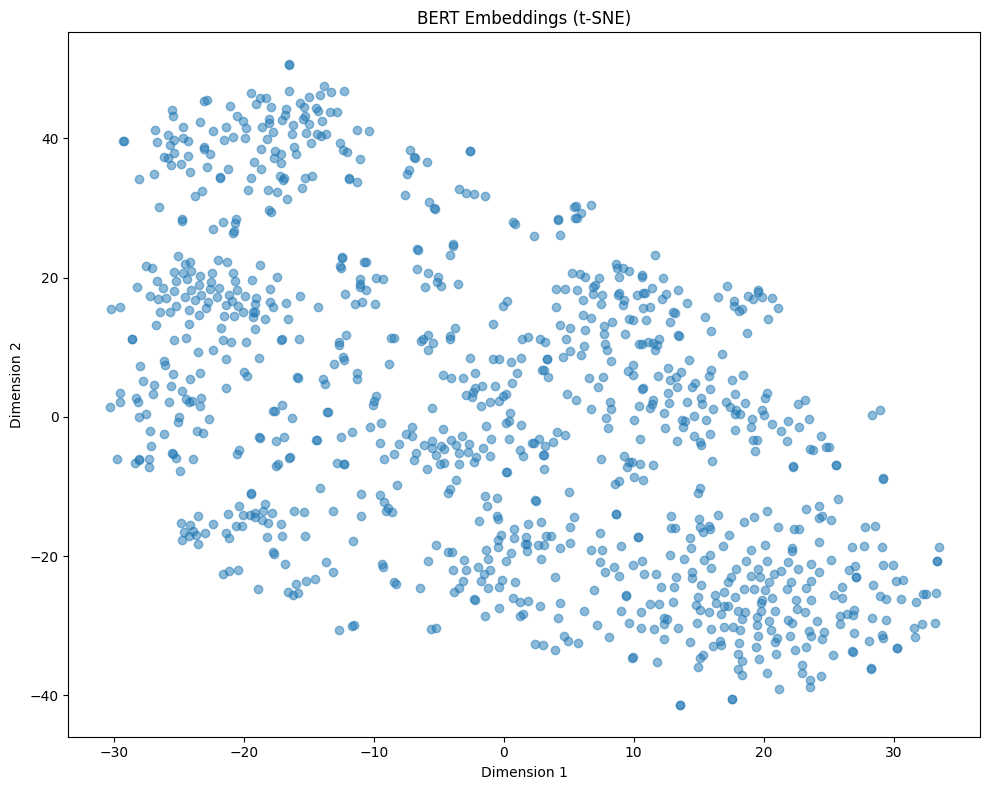

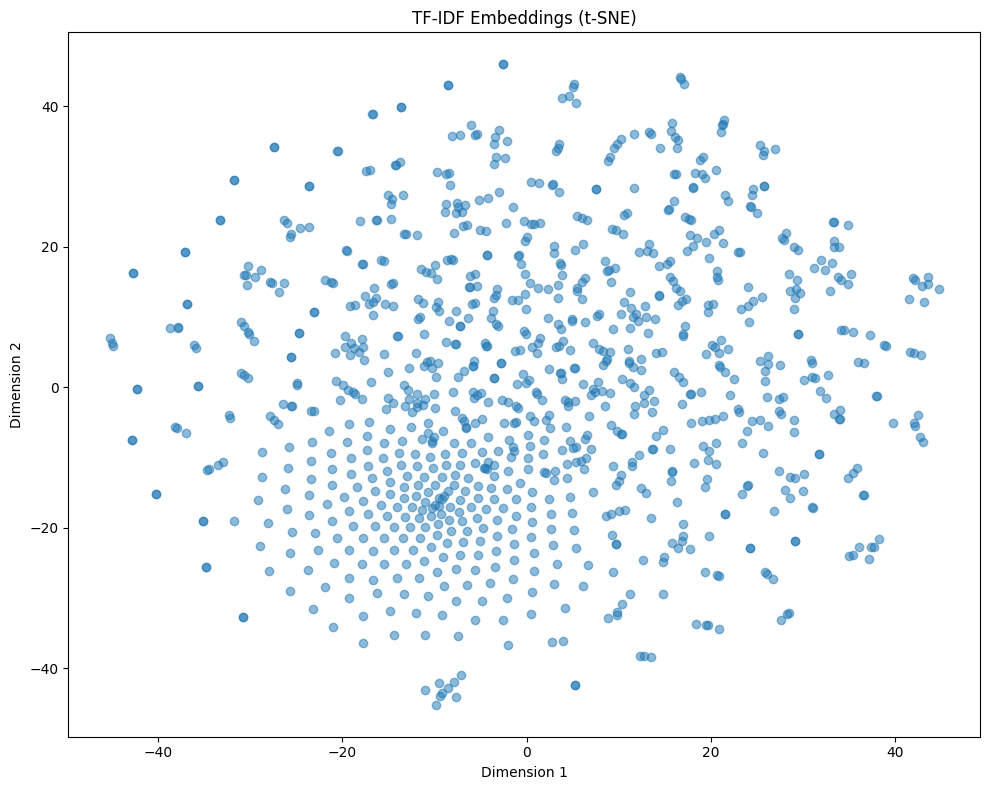

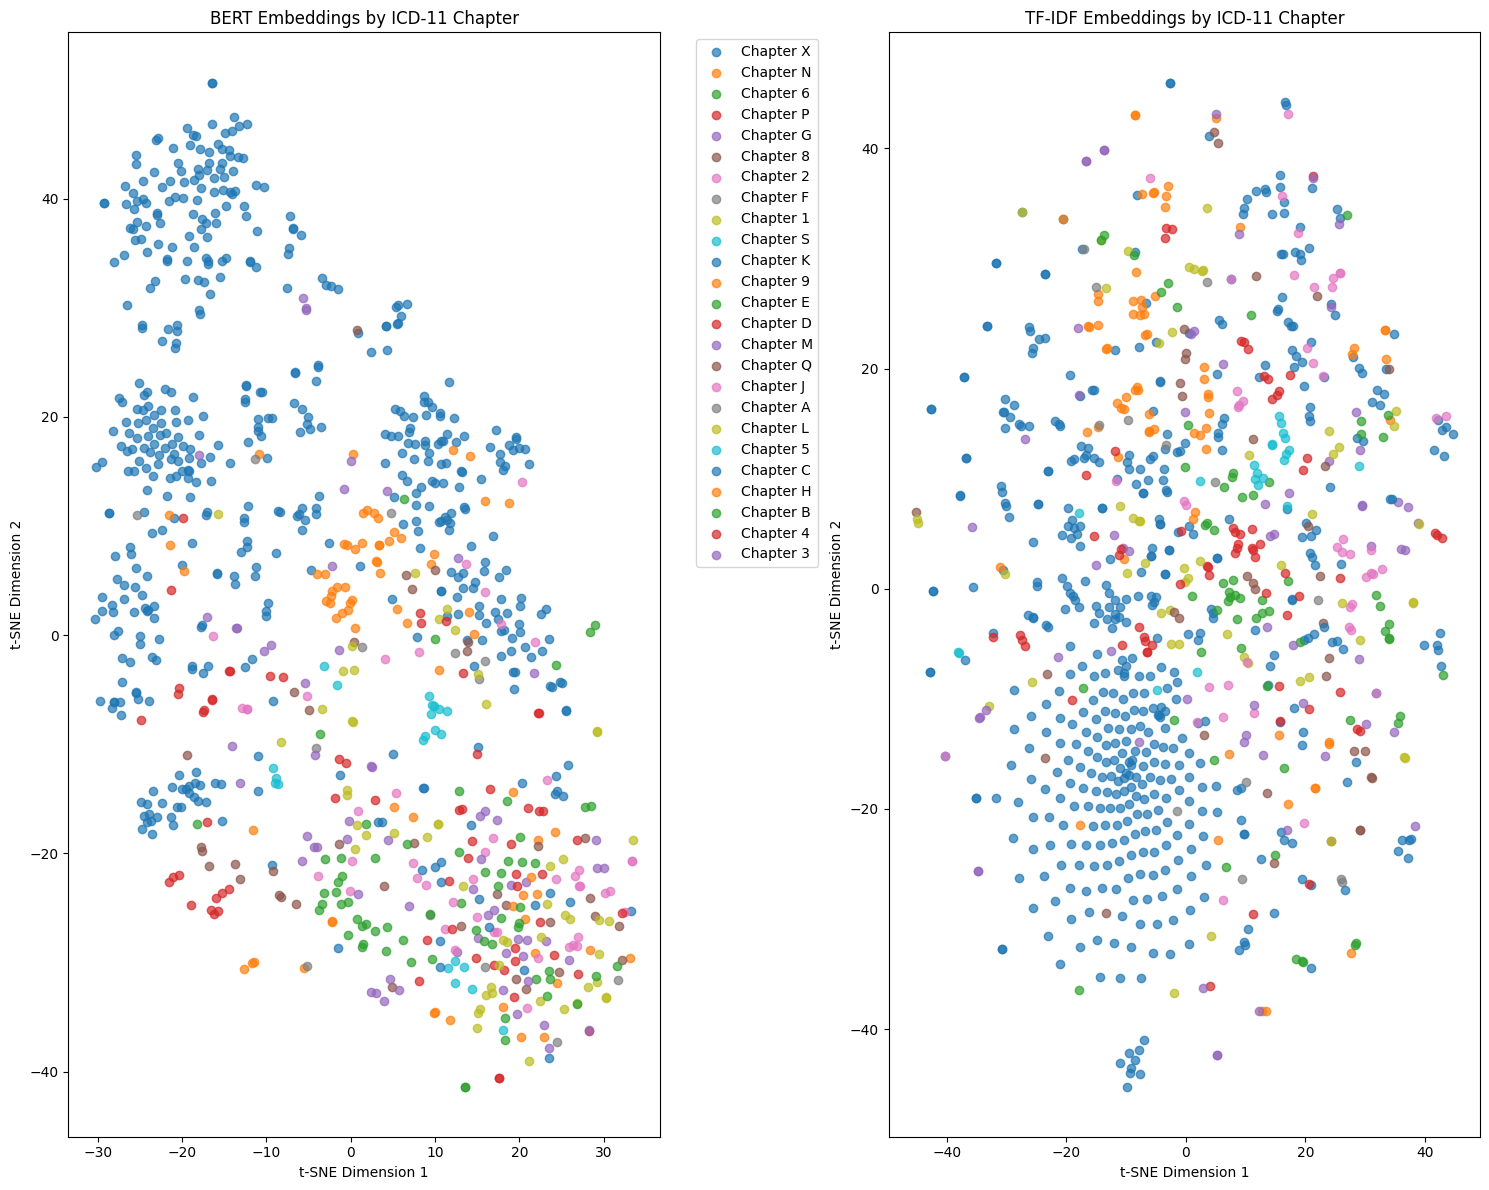

In [11]:
# Visualize the embeddings
print("\nCreating visualizations of the embedding spaces...")
def visualize_embeddings(vectors, title):
    """
    Create a t-SNE visualization of the embeddings.

    Parameters:
    -----------
    vectors : numpy.ndarray
        Array of embedding vectors
    title : str
        Title for the plot

    Returns:
    --------
    numpy.ndarray
        t-SNE reduced vectors
    """
    # Apply t-SNE dimensionality reduction
    tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vectors)-1))
    tsne_vectors = tsne.fit_transform(vectors)

    # Create scatter plot
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_vectors[:, 0], tsne_vectors[:, 1], alpha=0.5)
    plt.title(f"{title} Embeddings (t-SNE)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.tight_layout()
    plt.show()

    return tsne_vectors

# Visualize both embedding spaces
if len(sample_df) > 0:
    bert_vectors = np.array(sample_df['bert_vector'].tolist())
    tfidf_vectors = np.array(sample_df['tfidf_vector'].tolist())

    bert_tsne = visualize_embeddings(bert_vectors, "BERT")
    tfidf_tsne = visualize_embeddings(tfidf_vectors, "TF-IDF")

    # Visualize by ICD-11 chapter
    # Taking the first character of each code to determine its chapter
    sample_df['chapter'] = sample_df['code'].fillna('').apply(
        lambda x: x[0] if isinstance(x, str) and len(x) > 0 else 'Unknown'
    )

    # Plot the embeddings colored by chapter
    plt.figure(figsize=(15, 12))

    # BERT embeddings by chapter
    plt.subplot(1, 2, 1)
    for chapter in sample_df['chapter'].unique():
        if chapter == 'Unknown':
            continue
        indices = sample_df[sample_df['chapter'] == chapter].index
        if len(indices) > 0:
            plt.scatter(
                bert_tsne[indices, 0],
                bert_tsne[indices, 1],
                alpha=0.7,
                label=f"Chapter {chapter}"
            )
    plt.title("BERT Embeddings by ICD-11 Chapter")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # TF-IDF embeddings by chapter
    plt.subplot(1, 2, 2)
    for chapter in sample_df['chapter'].unique():
        if chapter == 'Unknown':
            continue
        indices = sample_df[sample_df['chapter'] == chapter].index
        if len(indices) > 0:
            plt.scatter(
                tfidf_tsne[indices, 0],
                tfidf_tsne[indices, 1],
                alpha=0.7,
                label=f"Chapter {chapter}"
            )
    plt.title("TF-IDF Embeddings by ICD-11 Chapter")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")

    plt.tight_layout()
    plt.show()

# 9. Contextual Understanding with BERT

In [12]:
# Function to demonstrate BERT's contextual understanding
def demonstrate_bert_context():
    """
    Demonstrate how BERT understands the same term differently in different contexts.
    """
    # Term with different meanings in medical contexts
    contexts = [
        ("discharge", "The patient is ready for discharge from the hospital."),
        ("discharge", "There was abnormal discharge from the wound."),
        ("heart", "The patient has a heart condition requiring medication."),
        ("heart", "At the heart of the problem is poor adherence to treatment.")
    ]

    embeddings = []
    for term, context in contexts:
        # Create a tokenized input
        encoded_input = tokenizer(context, return_tensors='pt')

        # Generate full BERT embeddings
        with torch.no_grad():
            outputs = model(**encoded_input)
            # Get all token embeddings
            token_embeddings = outputs.last_hidden_state[0]

        # Convert tokenizer indices to words
        tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0])

        # Find the term in the tokenized text
        term_indices = []
        for i, token in enumerate(tokens):
            if term.lower() in token.lower():
                term_indices.append(i)

        if term_indices:
            # Extract the embedding for the target term (average if split into subwords)
            term_embedding = token_embeddings[term_indices].mean(dim=0).numpy()
            embeddings.append((term, context, term_embedding))

    # Calculate similarities between the same term in different contexts
    print("\nDemonstrating BERT's contextual understanding:")
    for i in range(0, len(embeddings), 2):
        if i+1 < len(embeddings) and embeddings[i][0] == embeddings[i+1][0]:
            term = embeddings[i][0]
            context1 = embeddings[i][1]
            context2 = embeddings[i+1][1]
            embedding1 = embeddings[i][2]
            embedding2 = embeddings[i+1][2]

            # Calculate cosine similarity
            similarity = np.dot(embedding1, embedding2) / (
                np.linalg.norm(embedding1) * np.linalg.norm(embedding2)
            )

            print(f"\nTerm: '{term}'")
            print(f"Context 1: '{context1}'")
            print(f"Context 2: '{context2}'")
            print(f"Similarity between contexts: {similarity:.4f}")
            print("A lower similarity indicates BERT distinguishes different meanings based on context.")

# Demonstrate BERT's contextual understanding
demonstrate_bert_context()


Demonstrating BERT's contextual understanding:

Term: 'discharge'
Context 1: 'The patient is ready for discharge from the hospital.'
Context 2: 'There was abnormal discharge from the wound.'
Similarity between contexts: 0.5826
A lower similarity indicates BERT distinguishes different meanings based on context.

Term: 'heart'
Context 1: 'The patient has a heart condition requiring medication.'
Context 2: 'At the heart of the problem is poor adherence to treatment.'
Similarity between contexts: 0.3647
A lower similarity indicates BERT distinguishes different meanings based on context.


# 10. Natural Language Search for ICD Codes

In [13]:
# Function to search for ICD codes using natural language
def search_icd_codes(query, df, n=5):
    """
    Search for ICD-11 codes using natural language.

    Parameters:
    -----------
    query : str
        Natural language query
    df : pandas.DataFrame
        DataFrame containing codes and embeddings
    n : int
        Number of results to return

    Returns:
    --------
    list
        List of tuples containing (code, title, similarity score)
    """
    # Preprocess query
    processed_query = preprocess_text(query)

    # Get BERT embedding for query
    query_vector = get_bert_embedding(processed_query, model, tokenizer)

    # Calculate similarity with all codes
    similarities = []
    for idx, row in df.iterrows():
        if pd.isna(row['code']):
            continue

        vector = row['bert_vector']

        # Skip zero vectors
        if np.all(vector == 0):
            continue

        similarity = np.dot(query_vector, vector) / (np.linalg.norm(query_vector) * np.linalg.norm(vector))
        similarities.append((row['code'], row['title'], similarity))

    # Sort by similarity
    similarities.sort(key=lambda x: x[2], reverse=True)

    return similarities[:n]

# Demonstrate natural language search
print("\nDemonstrating natural language search for ICD codes:")
search_queries = [
    "patient with chest pain and shortness of breath",
    "chronic lower back pain",
    "high blood sugar levels",
    "recurring headaches with nausea"
]

for query in search_queries:
    print(f"\nQuery: '{query}'")
    results = search_icd_codes(query, sample_df)
    for code, title, similarity in results:
        print(f"  {code} - {title} (Score: {similarity:.4f})")


Demonstrating natural language search for ICD codes:

Query: 'patient with chest pain and shortness of breath'
  MD36 - Symptom or complaint of the throat (Score: 0.8994)
  2E85 - Benign fibrohistiocytic tumour (Score: 0.8849)
  XA3282 - Lateral rectus muscle (Score: 0.8816)
  ME86.21 - Back syndrome with radiating pain (Score: 0.8809)
  XA37J7 - Alveolar vein (Score: 0.8805)

Query: 'chronic lower back pain'
  DE10 - Vomiting following gastrointestinal surgery (Score: 0.8750)
  1B11.1 - Tuberculous meningoencephalitis (Score: 0.8731)
  XH0W31 - Lactating adenoma (Score: 0.8726)
  8D20.1 - Spastic bilateral cerebral palsy (Score: 0.8704)
  FA00 - Osteoarthritis of hip (Score: 0.8695)

Query: 'high blood sugar levels'
  DA0B.0 - Allergic gingivitis (Score: 0.8646)
  5C58.0 - Disorders of bilirubin metabolism or excretion (Score: 0.8617)
  1B21.2 - Cutaneous non-tuberculous mycobacterial infection (Score: 0.8558)
  MD36 - Symptom or complaint of the throat (Score: 0.8514)
  KA89.0 - Thr

# 11. Analyzing Medical Term Relationships

In [14]:
# Analyze BERT's understanding of medical relationships
def analyze_medical_relationships():
    """
    Analyze BERT's ability to capture relationships between medical terms.
    """
    # Medical term pairs (related terms)
    related_pairs = [
        ("heart", "cardiac"),
        ("lungs", "respiratory"),
        ("diabetes", "insulin"),
        ("brain", "neural"),
        ("kidney", "renal")
    ]

    # Function to get embedding for a term in medical context
    def get_term_embedding(term):
        context = f"The {term} is an important medical concept."
        return get_bert_embedding(context, model, tokenizer)

    print("\nAnalyzing BERT's understanding of medical terminology relationships:")
    for term1, term2 in related_pairs:
        # Get embeddings
        emb1 = get_term_embedding(term1)
        emb2 = get_term_embedding(term2)

        # Calculate cosine similarity
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        print(f"  Similarity between '{term1}' and '{term2}': {similarity:.4f}")

    # Compare with unrelated pairs
    unrelated_pairs = [
        ("heart", "diabetes"),
        ("lungs", "liver"),
        ("diabetes", "fracture"),
        ("brain", "kidney"),
        ("brain","pen"),
        ("arm","hello"),
        ("world","hi"),
        ("legs","Afghanistan")
    ]

    print("\nFor comparison, similarity between unrelated medical terms:")
    for term1, term2 in unrelated_pairs:
        emb1 = get_term_embedding(term1)
        emb2 = get_term_embedding(term2)
        similarity = np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))
        print(f"  Similarity between '{term1}' and '{term2}': {similarity:.4f}")

# Run the analysis
analyze_medical_relationships()


Analyzing BERT's understanding of medical terminology relationships:
  Similarity between 'heart' and 'cardiac': 0.9737
  Similarity between 'lungs' and 'respiratory': 0.9724
  Similarity between 'diabetes' and 'insulin': 0.9457
  Similarity between 'brain' and 'neural': 0.9793
  Similarity between 'kidney' and 'renal': 0.9746

For comparison, similarity between unrelated medical terms:
  Similarity between 'heart' and 'diabetes': 0.9481
  Similarity between 'lungs' and 'liver': 0.9662
  Similarity between 'diabetes' and 'fracture': 0.9533
  Similarity between 'brain' and 'kidney': 0.9625
  Similarity between 'brain' and 'pen': 0.9499



**Here we maybe have a problem, very different medical terms are still very correlated. Perhaps, BioBert can do better**

# 12. Hierarchical Relationships in ICD-11

In [15]:
# Function to analyze hierarchical relationships
def analyze_icd_hierarchy(df):
    """
    Analyze how well BERT captures the hierarchical structure of ICD-11.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing ICD-11 codes, parent IDs, and embeddings
    """
    # Extract parent-child relationships
    relationships = []

    for idx, row in df.iterrows():
        if pd.notna(row['parent']) and pd.notna(row['code']):
            parent_id = row['parent']
            child_code = row['code']

            # Find the parent in the dataset
            parent_rows = df[df['id'] == parent_id]
            if len(parent_rows) > 0:
                parent_row = parent_rows.iloc[0]
                if pd.notna(parent_row['code']):
                    relationships.append((
                        parent_row['code'],
                        parent_row['title'],
                        child_code,
                        row['title']
                    ))

    print(f"\nFound {len(relationships)} parent-child relationships in sample")

    if len(relationships) > 0:
        # Analyze BERT vs TF-IDF for hierarchical relationships
        bert_parent_child_sims = []
        tfidf_parent_child_sims = []

        for parent_code, parent_title, child_code, child_title in relationships:
            # Get the parent and child vectors
            parent_bert = df.loc[df['code'] == parent_code, 'bert_vector'].iloc[0]
            child_bert = df.loc[df['code'] == child_code, 'bert_vector'].iloc[0]

            parent_tfidf = df.loc[df['code'] == parent_code, 'tfidf_vector'].iloc[0]
            child_tfidf = df.loc[df['code'] == child_code, 'tfidf_vector'].iloc[0]

            # Calculate similarities
            bert_sim = np.dot(parent_bert, child_bert) / (
                np.linalg.norm(parent_bert) * np.linalg.norm(child_bert)
            )
            bert_parent_child_sims.append(bert_sim)

            tfidf_sim = np.dot(parent_tfidf, child_tfidf) / (
                np.linalg.norm(parent_tfidf) * np.linalg.norm(child_tfidf)
            )
            tfidf_parent_child_sims.append(tfidf_sim)

        # Calculate average similarities
        avg_bert_sim = np.mean(bert_parent_child_sims)
        avg_tfidf_sim = np.mean(tfidf_parent_child_sims)

        print("\nHierarchical relationship analysis:")
        print(f"  Average BERT parent-child similarity: {avg_bert_sim:.4f}")
        print(f"  Average TF-IDF parent-child similarity: {avg_tfidf_sim:.4f}")

        # Display some example relationships
        print("\nExample parent-child relationships:")
        for i, (parent_code, parent_title, child_code, child_title) in enumerate(relationships[:3]):
            print(f"  Parent: {parent_code} - {parent_title}")
            print(f"  Child: {child_code} - {child_title}")
            print(f"  BERT similarity: {bert_parent_child_sims[i]:.4f}")
            print(f"  TF-IDF similarity: {tfidf_parent_child_sims[i]:.4f}")
            print()

# Analyze hierarchical relationships
analyze_icd_hierarchy(sample_df)


Found 0 parent-child relationships in sample


**We should investigate this further**

# 13. Saving the Model and Embeddings

In [16]:
# Save the embeddings for future use
import pickle

def save_embeddings(df, filename):
    """
    Save the dataframe with BERT embeddings to a pickle file.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the codes and embeddings
    filename : str
        Path to save the pickle file
    """
    # Create a copy with just the necessary columns to save space
    save_df = df[['code', 'title', 'processed_text', 'bert_vector']].copy()

    try:
        with open(filename, 'wb') as f:
            pickle.dump(save_df, f)
        print(f"Successfully saved embeddings to {filename}")
        return True
    except Exception as e:
        print(f"Error saving embeddings: {e}")
        return False

def load_embeddings(filename):
    """
    Load the dataframe with BERT embeddings from a pickle file.

    Parameters:
    -----------
    filename : str
        Path to the pickle file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the codes and embeddings
    """
    try:
        with open(filename, 'rb') as f:
            df = pickle.load(f)
        print(f"Successfully loaded embeddings from {filename}")
        return df
    except Exception as e:
        print(f"Error loading embeddings: {e}")
        return None

# Save the embeddings
save_embeddings(sample_df, 'icd11_bert_embeddings.pkl')

Successfully saved embeddings to icd11_bert_embeddings.pkl


True

In [18]:
import pandas as pd
import numpy as np

def save_embeddings_to_csv(df, filename):
    """
    Save the dataframe with BERT embeddings directly to a CSV file.
    This handles the conversion of embedding vectors into separate columns.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the codes and embeddings
    filename : str
        Path to save the CSV file
    """
    # Create a copy with just the necessary columns to save space
    save_df = df[['code', 'title', 'processed_text']].copy()

    # Handle the embedding vectors - they need to be "unpacked" into separate columns
    # First, check the data structure of the bert_vector column
    first_vector = df['bert_vector'].iloc[0]

    print(f"Unpacking BERT vectors with dimension: {len(first_vector)}")

    # Create a new DataFrame with the embeddings unpacked into columns
    embedding_df = pd.DataFrame(df['bert_vector'].tolist())

    # Rename the embedding columns to make them more descriptive
    embedding_df.columns = [f'dim_{i}' for i in range(len(embedding_df.columns))]

    # Combine the original columns with the embedding columns
    result_df = pd.concat([save_df, embedding_df], axis=1)

    # Save to CSV
    try:
        result_df.to_csv(filename, index=False)
        print(f"Successfully saved embeddings to {filename}")
        print(f"CSV file shape: {result_df.shape}")
        print(f"Number of embedding dimensions saved: {len(embedding_df.columns)}")
        return True
    except Exception as e:
        print(f"Error saving embeddings to CSV: {e}")
        return False

def load_embeddings_from_csv(filename):
    """
    Load the dataframe with BERT embeddings from a CSV file.
    This reconstructs the vector format from the separate columns.

    Parameters:
    -----------
    filename : str
        Path to the CSV file

    Returns:
    --------
    pandas.DataFrame
        DataFrame containing the codes and embeddings with reconstructed vectors
    """
    try:
        # Load the CSV
        df = pd.read_csv(filename)
        print(f"Successfully loaded embeddings from {filename}")

        # Identify the embedding columns (those starting with 'dim_')
        embedding_cols = [col for col in df.columns if col.startswith('dim_')]

        # Extract the original columns and the embedding columns
        original_cols = [col for col in df.columns if not col.startswith('dim_')]

        # Create a new DataFrame with the original columns
        result_df = df[original_cols].copy()

        # Reconstruct the embedding vectors from the separate columns
        vectors = df[embedding_cols].values
        result_df['bert_vector'] = vectors.tolist()

        print(f"Reconstructed BERT vectors with dimension: {len(embedding_cols)}")
        return result_df
    except Exception as e:
        print(f"Error loading embeddings from CSV: {e}")
        return None

# Example usage:
# Save the embeddings
# save_embeddings_to_csv(sample_df, 'icd11_bert_embeddings.csv')

# Later, load the embeddings
# reconstructed_df = load_embeddings_from_csv('icd11_bert_embeddings.csv')

In [19]:
save_embeddings_to_csv(sample_df, 'icd11_bert_embeddings.csv')

Unpacking BERT vectors with dimension: 768
Successfully saved embeddings to icd11_bert_embeddings.csv
CSV file shape: (1000, 771)
Number of embedding dimensions saved: 768


True

# 14. Comparing TF-IDF and BERT

In [17]:
# Compare TF-IDF and BERT vectorization approaches
def compare_approaches():
    """Compare TF-IDF and BERT approaches for ICD-11 vectorization."""
    comparison = {
        "Feature": ["Contextual Understanding", "Semantic Relationships",
                   "Out-of-Vocabulary Handling", "Hierarchical Knowledge",
                   "Memory Requirements", "Processing Speed"],
        "TF-IDF": ["Limited", "Limited", "Poor", "Limited", "Lower", "Faster"],
        "BERT": ["Strong", "Strong", "Good", "Strong", "Higher", "Slower"]
    }

    df_comparison = pd.DataFrame(comparison)
    print("\nComparison of TF-IDF and BERT for ICD-11 Vectorization:")
    print(df_comparison.to_string(index=False))

    print("\nSummary of BERT Advantages:")
    print("1. Contextual Understanding:")
    print("   BERT creates different representations for the same term based on context,")
    print("   which is crucial for medical terminology where terms can have multiple meanings.")

    print("\n2. Semantic Relationships:")
    print("   BERT captures meaningful relationships between medical terms that may not")
    print("   co-occur in the same document, like 'heart' and 'cardiac'.")

    print("\n3. Hierarchical Knowledge:")
    print("   BERT better preserves parent-child relationships in the ICD-11 hierarchy,")
    print("   which is essential for understanding the structure of medical classification.")

    print("\n4. Natural Language Queries:")
    print("   BERT enables more effective searching for ICD codes using natural language,")
    print("   making it easier for healthcare professionals to find relevant codes.")

    print("\nTrade-offs:")
    print("- BERT requires more computational resources and memory.")
    print("- BERT processing is slower than TF-IDF.")
    print("- For very large datasets, implementation may require batching or distributed computing.")

# Compare approaches
compare_approaches()


Comparison of TF-IDF and BERT for ICD-11 Vectorization:
                   Feature  TF-IDF   BERT
  Contextual Understanding Limited Strong
    Semantic Relationships Limited Strong
Out-of-Vocabulary Handling    Poor   Good
    Hierarchical Knowledge Limited Strong
       Memory Requirements   Lower Higher
          Processing Speed  Faster Slower

Summary of BERT Advantages:
1. Contextual Understanding:
   BERT creates different representations for the same term based on context,
   which is crucial for medical terminology where terms can have multiple meanings.

2. Semantic Relationships:
   BERT captures meaningful relationships between medical terms that may not
   co-occur in the same document, like 'heart' and 'cardiac'.

3. Hierarchical Knowledge:
   BERT better preserves parent-child relationships in the ICD-11 hierarchy,
   which is essential for understanding the structure of medical classification.

4. Natural Language Queries:
   BERT enables more effective searching for I

I think there is a problem in the hierarchical relationship understanding